In [4]:
from gensim.models.word2vec_inner import get_pdist as pd
from gensim.models.word2vec_inner import get_psim as psim
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import os
import time

ROOT = "/Users/alext/Documents/Master/Thesis/"

# Generate random points inside the unit sphere.
def gen_points_inside_sphere(n, dtype=np.float64):
    xs = []
    for i in range(n):
        x = np.ones(3)
        while np.linalg.norm(x) >= 1:
            x = -1 + 2 * np.random.rand(3).astype(dtype)
        xs.append(x)
    return xs if n != 1 else xs[0]

a = np.array([0.001] * 3, dtype=np.float64)
o = np.array([0.0,0.0,0.0], dtype=np.float64)
print(psim(a, o)[0])
print(psim(100*a, o)[0])

-1.2000023999939975e-05
-0.12245659339735449


### Vector norm in Hyperbolic space

Text(0.5,0,'Euclidean norm')

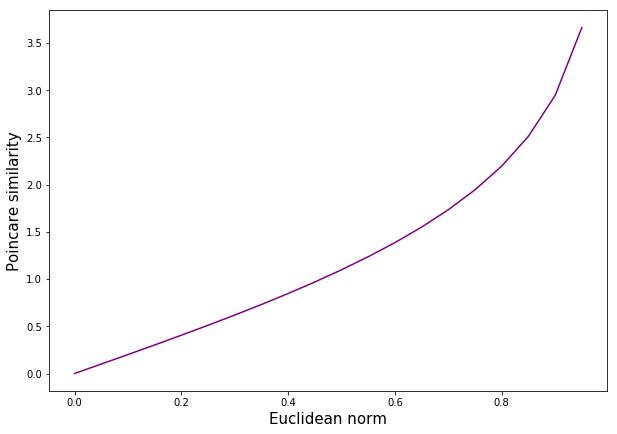

In [4]:
o = np.array([0.0,0.0,0.0], dtype=np.float64)
p = np.array([0.0, 0.0, 0.05], dtype=np.float64)

x = np.outer(range(20), p).astype(np.float64)
fig = plt.figure(figsize=(10, 7))

plt.plot(norm(x, axis=1), [pd(o, v) for v in x], color="purple")
plt.ylabel("Poincare similarity", fontsize=15)
plt.xlabel("Euclidean norm", fontsize=15)

### Distance in Hyperbolic space

Text(0.5,0,'Offset')

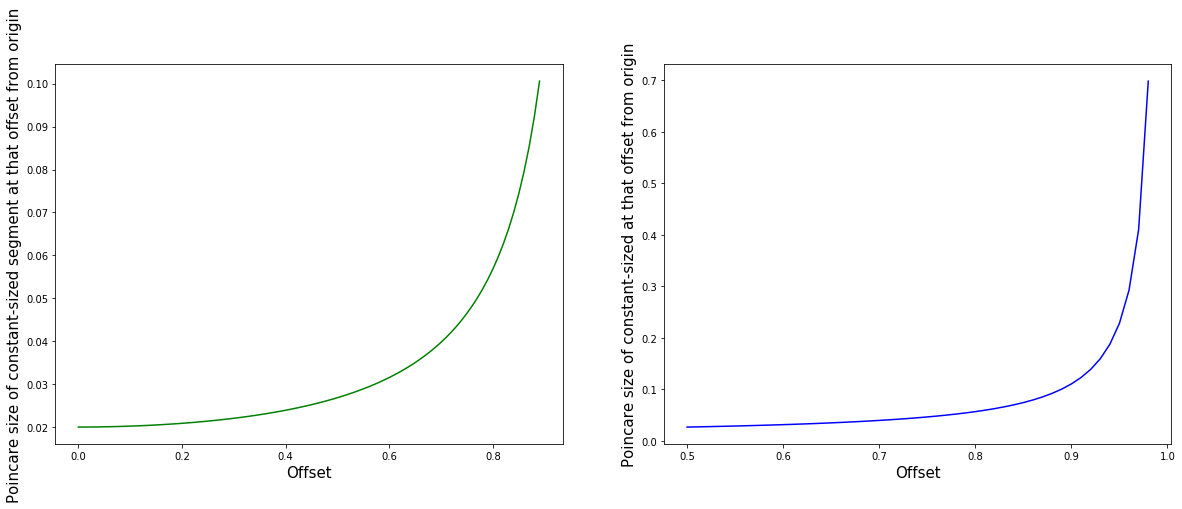

In [12]:
a = np.array([0.0,0.0,0.0], dtype=np.float64)
b = np.array([0.0, 0.0, 0.01], dtype=np.float64)
base_offset = np.array([0.0, 0.0, 0.01], dtype=np.float64)

fig = plt.figure(figsize=(20, 7))

plt.subplot(121)
offsets = np.outer(range(90), base_offset).astype(np.float64)
plt.plot(norm(offsets, axis=1), [pd(a+v, b+v) for v in offsets], color="green")
plt.ylabel("Poincare size of constant-sized segment at that offset from origin", fontsize=15)
plt.xlabel("Offset", fontsize=15)

plt.subplot(122)
offsets = np.outer(range(50, 99), base_offset).astype(np.float64)
plt.plot(norm(offsets, axis=1), [pd(a+v, b+v) for v in offsets], color="blue")
plt.ylabel("Poincare size of constant-sized at that offset from origin", fontsize=15)
plt.xlabel("Offset", fontsize=15)

### Benchmark Poincare distance implementations 
#### !!!! pd_moeb implementation is obsolete

In [13]:
num_calls = 100000
indexes = range(num_calls)
# Generate points in the 3D unit ball
xs = gen_points_inside_sphere(num_calls)
ys = gen_points_inside_sphere(num_calls)

# TODO: pd_moeb takes np.float32 as argument, not np.float64
# start = time.time()
# for i in indexes:
#     dist = pd_moeb(xs[i], ys[i])
# end = time.time()
# print("[Moebius distance] Took {} sec for {} function calls".format(end - start, num_calls))


start = time.time()
for i in indexes:
    dist = pd(xs[i], ys[i])
end = time.time()
print("[Poincare distance] Took {} sec for {} function calls".format(end - start, num_calls))

[Poincare distance] Took 0.1896822452545166 sec for 100000 function calls


### Gradient checking

In [31]:
import autograd.numpy as grad_np
from autograd import grad

np.random.seed(4)
A = gen_points_inside_sphere(1)
# A = o
print(A, np.linalg.norm(A))

# Poincare similarity = -poincare_dist(v, w)^2
def poincare_sim(v, w):
    g = 1 + 2 * grad_np.dot(v - w, v - w) / ((1 - grad_np.dot(v, v)) * (1 - grad_np.dot(w, w)))
    dist = grad_np.arccosh(g)
    return -dist * dist

def conformal_factor(x):
    tmp = 2 / (1 - np.dot(x, x))
    return tmp * tmp

def my_psim_grad_wrt_v(v, w=A):
    v = v.astype(np.float64)
    w = w.astype(np.float64)
    alpha_v = 1 - np.dot(v, v)
    beta_w = 1 - np.dot(w, w)
    f2 = alpha_v * beta_w
    squared_dist = np.dot(v-w, v-w)
    dg = 4 / f2 * (v - w + squared_dist / alpha_v * v)
    g = 1 + 2 * squared_dist / (alpha_v * beta_w)
    return -2 * np.arccosh(g) / np.sqrt(g * g - 1) * dg

num_points = 100000
indexes = range(num_points)
xs = gen_points_inside_sphere(num_points)

[ 0.42963199  0.39545765 -0.56782101] 0.814488241129921


### Benchmark Double vs Float Cython implementations

In [20]:
from gensim.models.word2vec_inner import get_pdist_float as pd_f

A_f = gen_points_inside_sphere(1, np.float32)
xs_f = gen_points_inside_sphere(num_points, np.float32)

def cython_result_sim_to_A_double(v):
    return psim(v, A)

def cython_result_dist_to_A_float(v):
    return pd_f(v, A_f)

# Cython double gradients.
start = time.time()
results = [cython_result_sim_to_A_double(x) for x in xs]
end = time.time()
print("[DOUBLE] Took {} sec to compute dist for {} points in Cython".format(end - start, num_points))


# Cython float gradients (for squared dist).
start = time.time()
results = [cython_result_dist_to_A_float(x) for x in xs_f]
end = time.time()
print("[FLOAT] Took {} sec to compute dist for {} points in Cython".format(end - start, num_points))

[DOUBLE] Took 0.3512990474700928 sec to compute dist for 100000 points in Cython
[FLOAT] Took 0.36156487464904785 sec to compute dist for 100000 points in Cython


#### Check gradients wrt v

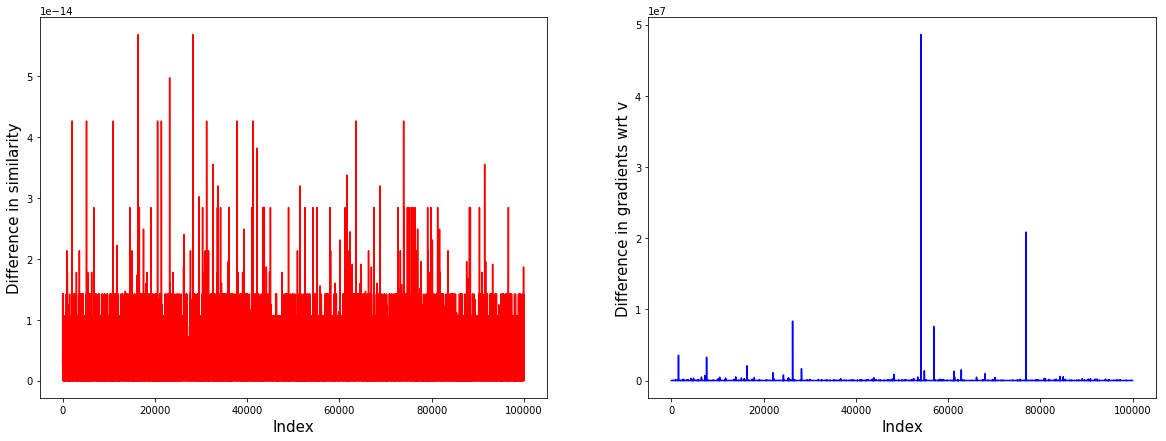

In [32]:
def autograd_sim_to_A(v):
    return poincare_sim(v, A)

def cython_result_sim_to_A(v):
    return psim(v, A)

# Cython gradients.
results = [cython_result_sim_to_A(x) for x in xs]
cython_similarities = np.array([r[0] for r in results])
cython_grads_wrt_v = np.array([np.array(r[1]) for r in results])

# Autograd gradients.
autograd_similarities = np.array([autograd_sim_to_A(x) for x in xs])
grad_wrt_v = grad(autograd_dist_to_A)
autograd_grads_wrt_v = np.array([grad_wrt_v(x) for x in xs])

my_psim_grads = np.array([my_psim_grad_wrt_v(x) for x in xs])

fig = plt.figure(figsize=(20, 7))

plt.subplot(121)
plt.plot(indexes, abs(cython_similarities - autograd_similarities), "red")
# plt.ylim(0, 1e-5)
plt.xlabel("Index", fontsize=15)
plt.ylabel("Difference in similarity", fontsize=15)

plt.subplot(122)
plt.plot(indexes, abs(np.linalg.norm(cython_grads_wrt_v - autograd_grads_wrt_v, axis=1)), "blue")
# plt.ylim(0, 1e-6)
plt.xlabel("Index", fontsize=15)
_ = plt.ylabel("Difference in gradients wrt v", fontsize=15)

#### Check gradients wrt w

[-0.13041694  0.55876584 -0.60462985]
[ 0.45969345 -0.5136119   0.46468219]
[ 19.74120998 -22.05669977  19.955448  ]


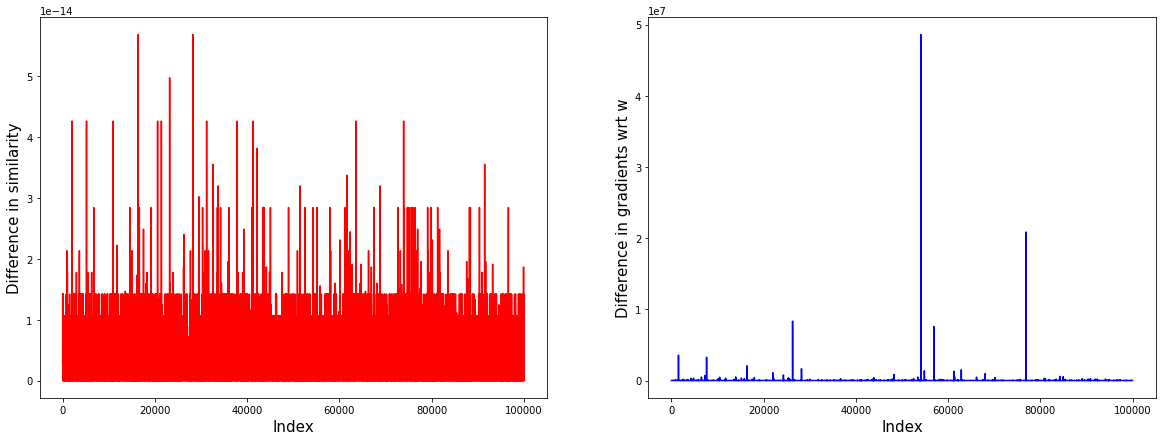

In [29]:
def autograd_sim_from_A(w):
    return poincare_sim(A, w)

def cython_result_sim_from_A(w):
    return psim(A, w)

# Cython gradients.
results = [cython_result_sim_from_A(x) for x in xs]
cython_similarities = np.array([r[0] for r in results])
cython_grads_wrt_w = np.array([np.array(r[2]) for r in results])

# Autograd gradients.
autograd_similarities = np.array([autograd_sim_from_A(x) for x in xs])
grad_wrt_w = grad(autograd_sim_from_A)
autograd_grads_wrt_w = np.array([grad_wrt_w(x) for x in xs])

print(xs[0])
print(cython_grads_wrt_w[0])
print(autograd_grads_wrt_w[0])

fig = plt.figure(figsize=(20, 7))

plt.subplot(121)
plt.plot(indexes, abs(cython_similarities - autograd_similarities), "red")
# plt.ylim(0, 1e-5)
plt.xlabel("Index", fontsize=15)
plt.ylabel("Difference in similarity", fontsize=15)

plt.subplot(122)
plt.plot(indexes, abs(np.linalg.norm(cython_grads_wrt_w - autograd_grads_wrt_w, axis=1)), "blue")
# plt.ylim(0, 1e-6)
plt.xlabel("Index", fontsize=15)
_ = plt.ylabel("Difference in gradients wrt w", fontsize=15)